# Problem 19: Shortest paths (total value: 6 points)

_Version 1.0b_

As a data analyst in the field, you will spend the bulk of your time just trying to get data into a form that is useful for analysis. This problem assess your ability to do that.

In particular, you will calculate shortest paths in the California road network. You will use SQL, pandas, and basic Python to transform the data so that it can be fed into [NetworkX](https://networkx.github.io/), a Python module for analyzing and visualizing graphs or networks.

This notebook has four (4) exercises, numbered 0 through 3, worth a total of **6 points**. Exercises 0 and 3 are worth 2 points each, and Exercises 1 and 2 are worth 1 point each.

**All exercises are independent, so if you get stuck on one, try moving on to the next one.** However, in such cases do look for notes labeled, _"In case Exercise XXX isn't working"_, as you may need to run some code cells that load pre-computed results that will allow you to continue with any subsequent exercises.

**Pro-tips.**
- If your program behavior seem strange, try resetting the kernel and rerunning everything.
- If you mess up this notebook or just want to start from scratch, save copies of all your partial responses and use `Actions` $\rightarrow$ `Reset Assignment` to get a fresh, original copy of this notebook. (_Resetting will wipe out any answers you've written so far, so be sure to stash those somewhere safe if you intend to keep or reuse them!_)
- If you generate excessive output (e.g., from an ill-placed `print` statement) that causes the notebook to load slowly or not at all, use `Actions` $\rightarrow$ `Clear Notebook Output` to get a clean copy. The clean copy will retain your code but remove any generated output. **However**, it will also **rename** the notebook to `clean.xxx.ipynb`. Since the autograder expects a notebook file with the original name, you'll need to rename the clean notebook accordingly.

**Good luck!**

## Background: The shortest path problem ##

The dataset in this problem is the California road network. It consists of **intersections**, which are point locations on the map having (x, y) coordinates, and **road (segments)**, each of which connects a pair of intersections. In the language of graphs or networks, we refer to intersections as _nodes_ and road segments as _edges_.

Run this code cell to see a picture of your task:

Example of what you will produce in this problem (shortest paths on the California road network):


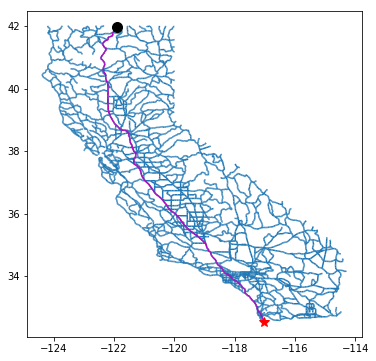

In [1]:
from problem_utils import get_path, display_image, assert_tibbles_are_equivalent, pandas_df_to_markdown_table
print("Example of what you will produce in this problem (shortest paths on the California road network):")
display_image(get_path('ca-roads-path-demo.png'))

The blue lines are road segments. The two markers (black solid circle and red star) are a source and destination pair. The purple route connecting this pair is a path, which is a list of connected road segments. The one you see in the image happens to be the "shortest path" between the source and destination.

**Your task in this notebook.** NetworkX can calculate the shortest path, but you have to supply the network. The exercises below walk you through the process of extracting the network data from a SQL database and transforming it so that NetworkX can use it.

**Preliminaries.** Run the following code cell, which will pre-load some modules you'll need for this problem.

In [2]:
import sys

import sqlite3 as db
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

print(f"* Python version:\n{sys.version}\n")
print(f"* sqlite3 version: {db.version}")
print(f"* pandas version: {pd.__version__}")

Matplotlib is building the font cache using fc-list. This may take a moment.


* Python version:
3.7.5 (default, Dec 18 2019, 06:24:58) 
[GCC 5.5.0 20171010]

* sqlite3 version: 2.6.0
* pandas version: 1.1.2


## Opening the database ##

Let's start by opening a read-only connection to the road network database:

In [3]:
conn = db.connect('file:' + get_path('ca-roads/network.db') + '?mode=ro', uri=True)

This database has two tables: `Intersections` and `Roads`. Let's take a look.

**Intersections.** The `Intersections` table looks like this:

In [4]:
pd.read_sql_query("SELECT * FROM Intersections LIMIT 7", conn)

,ID,X,Y
0,0,-121.904167,41.974556
1,1,-121.902153,41.974766
2,2,-121.896790,41.988075
3,3,-121.889603,41.998032
4,4,-121.886681,42.008739
5,5,-121.915062,41.970314
6,6,-121.910088,41.973942


Each intersection is a row in the database. It has a unique integer identifier (the `"ID"` column) and (x, y)-coordinates (the `"X"` and `"Y"` columns). You'll need the latter to visualize the paths.

**Roads.** The `Roads` table looks like this:

In [5]:
pd.read_sql_query("SELECT * FROM Roads LIMIT 5", conn)

,ID,AID,BID
0,0,0,1
1,1,0,6
2,2,1,2
3,3,2,3
4,4,3,4


Each road (segment) is a row of the table, with a unique integer ID (the `"ID"` column). It **connects** two intersections, and you can think of them as "point A" and "point B." The IDs of these two points are `"AID"` and `"BID"`.

> For example, row 1 of `Roads` is a road segment whose ID is also 1. It connects intersections 0 and 6. Recalling the `Intersections` table from before, intersection 0 has physical coordinates of (-121.904167, 41.974556), and intersection 6 has coordinates (-121.910088, 41.973942).

## Exercise 0 (2 points): Querying the roads geometry ##

Let's pull the road and intersection data together. In the code cell below, create a query string named `query_roads` that will produce an output table with exactly the following 7 columns:

- `E`: The road segment ID
- `A`: Point A of the road segment
- `AX`: The x-coordinate of point A
- `AY`: The y-coordinate of point A
- `B`: Point B of the road segment
- `BX`: The x-coordinate of point B
- `BY`: The y-coordinate of point B

The "demo" below will run your query string against the database, returning the result in a pandas `DataFrame` object named `df_roads`.

For example, a few rows of your output should be:

E|A|AX|AY|B|BX|BY
---|---|---|---|---|---|---
0|0|-121.90416699999999|41.974556|1|-121.902153|41.974765999999995
1|0|-121.90416699999999|41.974556|6|-121.91008799999999|41.973942
2|1|-121.902153|41.974765999999995|2|-121.89679|41.988075
3|2|-121.89679|41.988075|3|-121.88960300000001|41.998032
4|3|-121.88960300000001|41.998032|4|-121.88668100000001|42.008739
...

In [23]:
# Define a variable named `query_roads`:
###
query_roads = ''' SELECT  V.E, V.A, V.AX, V.AY, V.BID as B, I.X as BX, I.Y as BY
FROM(
SELECT R.ID AS E, R.AID as A, I.X AS AX, I.Y AS AY, BID
FROM Roads R 
join Intersections I on R.AID = I.ID
GROUP BY E, A, AX, AY, BID) V
join Intersections I on V.BID = I.ID

'''
###

# Demo of your query:
df_roads = pd.read_sql_query(query_roads, conn)
df_roads.head()

,E,A,AX,AY,B,BX,BY
0,0,0,-121.904167,41.974556,1,-121.902153,41.974766
1,2,1,-121.902153,41.974766,2,-121.896790,41.988075
2,3,2,-121.896790,41.988075,3,-121.889603,41.998032
3,4,3,-121.889603,41.998032,4,-121.886681,42.008739
4,1,0,-121.904167,41.974556,6,-121.910088,41.973942


In [24]:
# Test cell: `ex0__query_roads` (2 points)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

def ex0_gen_dfs():
    global query_roads # Your query
    from random import randint, random, sample
    from itertools import combinations
    from pandas import DataFrame
    
    num_ints = randint(3, 5)
    ids = list(range(num_ints))
    xs, ys = [], []
    for v in ids:
        xs.append(-1 + 2*random())
        ys.append(-1 + 2*random())
    df_ints = DataFrame({"ID": ids, "X": xs, "Y": ys})
    
    all_roads = list(combinations(ids, 2))
    num_roads = randint(1, len(all_roads))
    roads = set()
    for a, b in sample(all_roads, num_roads):
        roads |= {(a, b)}
    rr, aa, bb = [], [], []
    for r, (a, b) in enumerate(roads):
        rr += [r]
        aa += [a]
        bb += [b]
    axs = [xs[a] for a in aa]
    ays = [ys[a] for a in aa]
    bxs = [xs[b] for b in bb]
    bys = [ys[b] for b in bb]
    df_roads = DataFrame({"ID": rr, "AID": aa, "BID": bb})
    df_soln = DataFrame({"E": rr,
                         "A": aa, "AX": axs, "AY": ays,
                         "B": bb, "BX": bxs, "BY": bys})
    return df_ints, df_roads, df_soln

def ex0_check_one():
    from sqlite3 import connect
    from pandas import read_sql_query
    
    # Randomly generate a sample problem (and solution)
    df_ints, df_roads, df_soln = ex0_gen_dfs()
    
    # Create a database
    db_conn = connect(":memory:")
    df_ints.to_sql("Intersections", db_conn)
    df_roads.to_sql("Roads", db_conn)
    
    # Try your query
    try:
        df_your_soln = read_sql_query(query_roads, db_conn)
        assert_tibbles_are_equivalent(df_soln, df_your_soln)
    except:
        print("\n*** ERROR ***\n")
        print("Your code did not produce the expected result on a randomly generated input.")
        print("==> Intersections:")
        display(df_ints)
        print("==> Roads:")
        display(df_roads)
        print("==> Expected solution:")
        display(df_soln)
        print("==> Your solution:")
        display(df_your_soln)
        raise
    finally:
        db_conn.close()

print()
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex0_check_one()

print("\n(Passed.)")


=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


/mnt/data2/students/sub1/ccc_v1_w_ZTU1O_92444/asn209363_22/asn272984_20/work/problem_utils.py:61: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)


### A pre-generated road network ###

Whether you solved Exercise 0 or not, the following code cell will load a pre-generated solution for these data and store them in a pandas `DataFrame` called `df_roads`, so you can continue with the problem. Run this cell now. Subsequent exercises depend on `df_roads`, so do **not** modify it.

In [25]:
df_roads = pd.read_csv(get_path("ca-roads/ex0_soln.csv"))
display(df_roads.head())
print("...")

,E,A,AX,AY,B,BX,BY
0,0,0,-121.904167,41.974556,1,-121.902153,41.974766
1,1,0,-121.904167,41.974556,6,-121.910088,41.973942
2,2,1,-121.902153,41.974766,2,-121.896790,41.988075
3,3,2,-121.896790,41.988075,3,-121.889603,41.998032
4,4,3,-121.889603,41.998032,4,-121.886681,42.008739


...


## Basic visualization ##

Before the next exercise, run this cell to define some code that will help us draw the road network.

In [26]:
def node_coords(sx, sy):
    return [(x, y) for x, y in zip(sx, sy)]

def edge_coords(axy, bxy):
    return [[a, b] for a, b in zip(axy, bxy)]

def plot_roads(df, ax=None):
    from matplotlib.pyplot import gca
    from matplotlib.collections import LineCollection
    if ax is None: ax = gca()
    A = node_coords(df["AX"], df["AY"])
    B = node_coords(df["BX"], df["BY"])
    E = edge_coords(A, B)
    ec = LineCollection(E)
    ax.add_collection(ec)
    ax.autoscale()

def plot_point(x, y, markerstyle):
    from matplotlib.pyplot import plot
    plot(x, y, markerstyle, markersize=10)
    
def get_intersection_coords(i, df):
    return df["X"].iloc[i], df["Y"].iloc[i]

To see this visualization in action, let's load all intersections, and consider the first one (first row) and the last one (last row):

In [27]:
df_intersections = pd.read_sql_query("SELECT * FROM Intersections", conn)

i_first = 0
i_last = -1
display(df_intersections.iloc[[i_first, i_last]])

,ID,X,Y
0,0,-121.904167,41.974556
21047,21047,-117.035332,32.541302


Let's draw the road network and mark these two intersections:

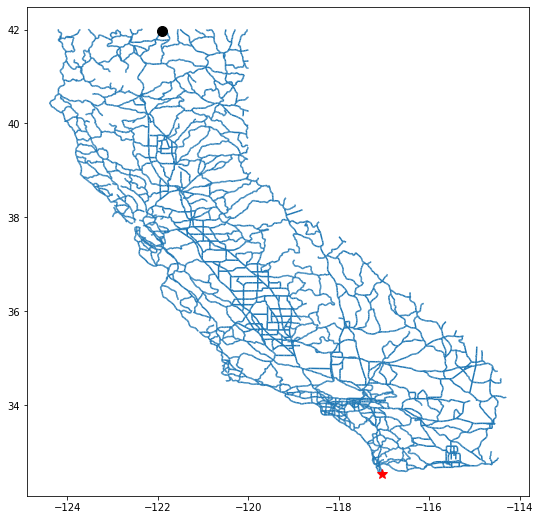

In [28]:
plt.figure(figsize=(9, 9))
plot_roads(df_roads)
plot_point(*get_intersection_coords(i_first, df_intersections), 'ko')
plot_point(*get_intersection_coords(i_last, df_intersections), 'r*')

**Closing the database.** The cells below assume the use of pandas, not SQL. For this reason, the next code cell will close the database connection. If for some reason you think you need to leave it open, then comment out this line (but do try to remember to close the connection later!).

In [29]:
conn.close() # Close the SQL database for good measure

## Exercise 1 (1 point): Calculating road segment lengths ##

To calculate the shortest path between any two intersections, we need to know the lengths of each road segment.

Let's use the Euclidean distance as our measure of length. That is, let $a$ and $b$ be two intersections whose (x, y)-coordinates are $(x_a, y_a)$ for point $a$ and $(x_b, y_b)$ for point $b$. Then the Euclidean distance $d(a,b)$ between them is

$$
d(a, b) \equiv \sqrt{(x_b - x_a)^2 + (y_b - y_a)^2}.
$$

Unfortunately, sqlite3 does **not** have an easy built-in way to compute square roots. Therefore, let's switch to using pandas, now that we've extracted the main tables we need.

Complete the function `calc_distances(df)`, below. Assume that the input data frame, `df`, is one generated by your query in Exercise 0, e.g., it has the form,

E|A|AX|AY|B|BX|BY
---|---|---|---|---|---|---
0|0|-121.90416699999999|41.974556|1|-121.902153|41.974765999999995
1|0|-121.90416699999999|41.974556|6|-121.91008799999999|41.973942
2|1|-121.902153|41.974765999999995|2|-121.89679|41.988075
3|2|-121.89679|41.988075|3|-121.88960300000001|41.998032
4|3|-121.88960300000001|41.998032|4|-121.88668100000001|42.008739
...

Your function should return a new pandas `DataFrame` with just two columns: `E`, holding the road segment ID, and `L`, holding the Euclidean length of that segment. For instance, the result for the rows shown above would be

E|L
---|---
0|0.0020249187638055285
1|0.005952750372727481
2|0.01434891110851333
3|0.012279854152229423
4|0.011098555446539574

For instance, consider segment 2. Its length is

$$\sqrt{(-121.89679 - (-121.902153))^2 + (41.988075 - 41.974765999999995)^2)} \approx 0.01434891111\ldots,$$

as indicated above.

In [30]:
def calc_distances(df):
    ###

    df['L'] = ((df['BX']-df['AX'])**2 +((df['BY']-df['AY'])**2))**0.5
    return df[['E','L']]
    ###

df_distances = calc_distances(df_roads)
df_distances.head()

,E,L
0,0,0.002025
1,1,0.005953
2,2,0.014349
3,3,0.012280
4,4,0.011099


In [31]:
# Test cell: `ex1__calc_distances` (1 point)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

def ex1_gen_df():
    from random import randint, random, sample
    from itertools import combinations
    from pandas import DataFrame
    from math import sqrt
    
    def euclidean(ax, ay, bx, by):
        return sqrt((bx - ax)**2 + (by - ay)**2)

    num_ints = randint(3, 5)
    ids = list(range(num_ints))
    xs, ys = [], []
    for v in ids:
        xs.append(-1 + 2*random())
        ys.append(-1 + 2*random())
    all_roads = list(combinations(ids, 2))
    num_roads = randint(1, len(all_roads))
    roads = set()
    for a, b in sample(all_roads, num_roads):
        roads |= {(a, b)}
    rr, aa, bb = [], [], []
    for r, (a, b) in enumerate(roads):
        rr += [r]
        aa += [a]
        bb += [b]
    axs = [xs[a] for a in aa]
    ays = [ys[a] for a in aa]
    bxs = [xs[b] for b in bb]
    bys = [ys[b] for b in bb]
    ll = [euclidean(ax, ay, bx, by) for ax, ay, bx, by in zip(axs, ays, bxs, bys)]
    df = DataFrame({"E": rr,
                    "A": aa, "AX": axs, "AY": ays,
                    "B": bb, "BX": bxs, "BY": bys})
    df_soln = DataFrame({"E": rr, "L": ll})
    return df, df_soln

def ex1_check_one():
    df, df_soln = ex1_gen_df()
    try:
        df_your_soln = calc_distances(df)
        assert_tibbles_are_equivalent(df_soln, df_your_soln)
    except:
        print("\n*** ERROR ***\n")
        print("Your code did not produce the expected solution.")
        print("Input data frame:")
        display(df)
        print("Expected solution:")
        display(df_soln)
        print("Your solution:")
        display(df_your_soln)
        raise

print()
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex1_check_one()

print("\n(Passed.)")


=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


/mnt/data2/students/sub1/ccc_v1_w_ZTU1O_92444/asn209363_22/asn272984_20/work/problem_utils.py:61: FutureWarning: The 'check_less_precise' keyword in testing.assert_*_equal is deprecated and will be removed in a future version. You can stop passing 'check_less_precise' to silence this warning.
  assert_frame_equal(A_c, B_c, check_index_type=False, check_less_precise=True)


### Pre-computed distances ###

Whether you solved Exercise 1 successfully or not, the following code cell will load a pre-generated solution for these data and store them in a pandas `DataFrame` called `df_distances`, so that you can continue with the problem. Subsequent exercises depend on `df_distances`, so do **not** modify it.

In [32]:
df_distances = pd.read_csv(get_path("ca-roads/ex1_soln.csv"))
display(df_distances.head())
print("...")

,E,L
0,0,0.002025
1,1,0.005953
2,2,0.014349
3,3,0.012280
4,4,0.011099


...


##  Edge lists ##

To use NetworkX, a _graph_ or _network_ is a collection of _nodes_ (or _vertices_) and _edges_, which connect nodes. For instance, in the road network, intersections are nodes and roads are edges. In the airport network of Notebook 11, airports were nodes and direct flight segments were edges. And in a social network, a person is a node and a friendship connection is an edge.

As a starting step, let's combine the `df_roads` and `df_distances` data frames into a single data frame, called `df_edges`:

In [33]:
df_edges = df_roads.merge(df_distances, on="E")
df_edges.head()

,E,A,AX,AY,B,BX,BY,L_x,L_y
0,0,0,-121.904167,41.974556,1,-121.902153,41.974766,0.002025,0.002025
1,1,0,-121.904167,41.974556,6,-121.910088,41.973942,0.005953,0.005953
2,2,1,-121.902153,41.974766,2,-121.896790,41.988075,0.014349,0.014349
3,3,2,-121.896790,41.988075,3,-121.889603,41.998032,0.012280,0.012280
4,4,3,-121.889603,41.998032,4,-121.886681,42.008739,0.011099,0.011099


NetworkX requires us to define nodes and edges in a certain way. For nodes, we can just use the intersection IDs as node IDs.

For edges, we need to construct an _edge list_. An edge list is a list of tuples of the form, `(a, b, s)`, where

- `a` represents one node ID of a given edge;
- `b` represents the other node ID of that edge;
- and `s` is a dictionary of attributes (possibly empty).

We'll explain how we'll use `s` in the next exercise, where you'll create an edge list for our data.

## Exercise 2 (1 point): Creating an edge list ##

Complete the function `get_edgelist(df)`, below.

The input data frame, `df`, will be something that looks like the `df_edges` data frame from above, that is, a tibble of road segments with intersection IDs (columns `"A"` and `"B"`), coordinates (`"AX"`, `"AY"`, `"BX"`, `"BY"`), and segment length (`"L"`).

Your function should convert this data frame into a Python list of edge-tuples, $[(a_0, b_0, s_0), (a_1, b_1, s_1), \ldots]$ such that for each edge $k$,

- $(a_k, b_k)$ are the intersection IDs of road segment $k$; and
- $s_k$ is a dictionary with exactly one key, `"w"`, whose value is the length of segment $k$.

For example, for the first five rows of `df_edges` above, the returned list would have the elements

```python
    [(0, 1, {'w': 0.002025}),
     (0, 6, {'w': 0.005953}),
     (1, 2, {'w': 0.014349}),
     (2, 3, {'w': 0.012280}),
     (3, 4, {'w': 0.011099}),
     ...]
```

> **Note 0.** The intersection IDs in your solution must be of type `int`.
>
> **Note 1.** Your solution should not depend on the order of the columns in `df`. The test cell may check your code on data frames where, for instance, `"L"` is the second column or `"L"` is the last column.

In [42]:
def get_edgelist(df):
    ###
    l = []
    e = df.copy()
    e =  e.rename(columns = {'L_x':'L'})
    for index, row in e.iterrows():
        l.append((int(row['A']),int(row['B']), {'w':row['L']} ))
    return l
    ###
    
# Demo
edgelist = get_edgelist(df_edges)
edgelist[:5]

[(0, 1, {'w': 0.0020249187638055285}),
 (0, 6, {'w': 0.005952750372727481}),
 (1, 2, {'w': 0.01434891110851333}),
 (2, 3, {'w': 0.012279854152229423}),
 (3, 4, {'w': 0.011098555446539574})]

In [43]:
# Test cell: `ex2__get_edgelist` (1 point)

###
### AUTOGRADER TEST - DO NOT REMOVE
###

def ex2_gen_df():
    from random import randint, random, sample
    from itertools import combinations
    from pandas import DataFrame
    from math import sqrt
    
    def euclidean(ax, ay, bx, by):
        return sqrt((bx - ax)**2 + (by - ay)**2)

    num_ints = randint(3, 5)
    ids = list(range(num_ints))
    xs, ys = [], []
    for v in ids:
        xs.append(-1 + 2*random())
        ys.append(-1 + 2*random())
    all_roads = list(combinations(ids, 2))
    num_roads = randint(1, len(all_roads))
    roads = set()
    for a, b in sample(all_roads, num_roads):
        roads |= {(a, b)}
    rr, aa, axs, ays, bb, bxs, bys, ll = [], [], [], [], [], [], [], []
    soln_list = []
    for r, (a, b) in enumerate(roads):
        rr += [r]
        aa += [a]
        axs += [xs[a]]
        ays += [ys[a]]
        bb += [b]
        bxs += [xs[b]]
        bys += [ys[b]]
        ll += [euclidean(axs[-1], ays[-1], bxs[-1], bys[-1])]
        soln_list.append((a, b, {'w': ll[-1]}))
    df = DataFrame({"E": rr, "L": ll,
                    "A": aa, "AX": axs, "AY": ays,
                    "B": bb, "BX": bxs, "BY": bys})
    return df, soln_list

def ex2_check_one():
    from math import isclose
    def soln_to_dict(soln):
        assert isinstance(soln, list), f"*** Solution should be a list, not `{type(soln)}`. ***"
        soln_dict = {}
        for k, x in enumerate(soln):
            assert isinstance(x, tuple), f"*** Element {k} == '{x}', which is a `{type(x)}`, not a `{type(tuple())}`. ***"
            assert len(x) == 3, f"*** Element {k} == '{x}' has {len(x)} values instead of just 3. ***"
            assert isinstance(x[-1], dict), \
                   f"*** For element {k} == '{x}', third component is a `{type(x[-1])}` rather than a `dict`. ***"
            assert 'w' in x[-1], f"*** The dictionary at element {k} == '{x}' does not have a 'w' key. ***"
            soln_dict[(x[0], x[1])] = x[2]
        return soln_dict
    
    df, soln_list = ex2_gen_df()
    soln_dict = soln_to_dict(soln_list)
    try:
        your_soln_list = get_edgelist(df)
        your_soln_dict = soln_to_dict(your_soln_list)
        for (ura, urb), urs in your_soln_dict.items():
            assert (ura, urb) in soln_dict, f"*** Edge ({ura}, {urb}) is not in the expected solution. ***"
            assert isclose(urs['w'], soln_dict[(ura, urb)]['w']), \
                   f"*** For ({ura}, {urb}), weight {urs['w']} does not match ours, {soln_dict[(ura, urb)]}. ***"
    except:
        print("\n*** ERROR: Your results don't match our expectations. ***\n")
        print("==> Input data frame:")
        display(df)
        print("==> Expected output:")
        print(soln_list)
        print("==> Your output:")
        print(your_soln_list)
        raise
        
print()
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex2_check_one()

print("\n(Passed.)")


=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


### A pre-computed edge list ###

Whether you solved Exercise 2 or not, the following code cell will load a pre-generated solution for these data and store them in a list called `edgelist`, so that you can continue with this problem. Subsequent exercises depend on `df_distances`, so do **not** modify it.

In [44]:
with open(get_path("ca-roads/ex2_soln.csv"), "rt") as fp:
    edgelist = []
    for l in fp.readlines():
        a, b, s = l.strip().split(',')
        edgelist.append((int(a), int(b), {'w': float(s)}))
        
print("First five edges:")
for e in edgelist[:5]:
    print(e)
print("...")

First five edges:
(0, 1, {'w': 0.0020249187638055285})
(0, 6, {'w': 0.005952750372727481})
(1, 2, {'w': 0.014348911108513331})
(2, 3, {'w': 0.012279854152229423})
(3, 4, {'w': 0.011098555446539574})
...


## Computing shortest paths via NetworkX ##

At last, we are ready to calculate shortest paths!

First, let's create a NetworkX `Graph` object with intersections as nodes and the edge list from Exercise 2.

> By default, NetworkX treats the graph as _undirected_. So edge (0, 6) and (6, 0) are treated as the same.

In [45]:
from networkx import Graph
G = Graph()
G.add_nodes_from(df_intersections["ID"])
G.add_edges_from(edgelist)

print(f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

The graph has 21048 nodes and 21693 edges.


Once we have a graph, asking for a shortest path between two nodes is easy! First, recall that each element of our edge list had two end points, $a$ and $b$, as well as the distance between them. When we build the graph, we will ask NetworkX to use the distances as _weights_ along each edge. Then, when searching for a shortest path, NetworkX will use these edge weights to calculate the length of a path, and the shortest path will be the one where the sum of edge weights is minimized.

The following code uses NetworkX to compute the path between node (intersection) `start` and `finish`:

In [46]:
def get_shortest_path(s, t, G):
    from networkx import shortest_path
    return shortest_path(G, source=s, target=t, weight='w')

start = df_intersections["ID"].iloc[i_first]
finish = df_intersections["ID"].iloc[i_last]
print(f"Calculating a shortest path between nodes (intersections) {start} and {finish}...")
path = get_shortest_path(start, finish, G)

print(f"\n==> First ten nodes (intersections) along the path, which is of type `{type(path)}`:")
print('    ' + ', '.join([str(s) for s in path[:10]]) + ", ...")

Calculating a shortest path between nodes (intersections) 0 and 21047...

==> First ten nodes (intersections) along the path, which is of type `<class 'list'>`:
    0, 6, 5, 7, 265, 264, 263, 262, 261, 260, ...


The `path` is a list of nodes (intersections). For instance, if the path were the list,

```python
[8, 2, 6, 3, 10, 11, 104, 52]
```

then that would mean the shortest path starts at node 8, then goes along the edge from 8 to 2, then along the edge from 2 to 6, and so on.

## Exercise 3 (2 points): Edge coordinates, for plotting ##

As your last exercise, let's take a path and determine the coordinates of each edge, producing an _edge coordinates list_. It's easiest to see by example.

**Example.** Suppose the coordinates of these nodes is given in an intersections data frame, `df`, which is the following:

ID|X|Y
---|---|---
0|-121.90416699999999|41.974556
5|-121.915062|41.970314
6|-121.91008799999999|41.973942
7|-121.916199|41.969482

Now suppose you are given the following path between nodes 0 and 7: `path = [0, 6, 5, 7]`.

The _edge coordinates list_ of this path is a list with one element per edge of the path. In this example, the edges of the path are (0, 6), (6, 5), and (5, 7), so the edge coordinates list will have three elements. Each element is also a list. Each inner list has two elements, which are two (x, y)-coordinate pairs. In our example.

```python
    [[(-121.90416699999999, 41.974556), (-121.91008799999999, 41.973942)], # (x, y) for 0 and 6
     [(-121.91008799999999, 41.973942), (-121.915062, 41.970314)], # (x, y) for 6 and 5
     [(-121.915062, 41.970314), (-121.916199, 41.969482)] # (x, y) for 5 and 7
    ]
```

**Your task.** Complete the function, `path_to_coords(path, df)`, so that it computes the edge coordinates list for a path, `path`, whose node coordinates are given by `df`. That is, `path` will be a list of node IDs and `df` will hold the coordinates where column `"ID"` holds the node ID, `"X"` the x-coordinate, and `"Y"` the y-coordinate. It should return this edge coordinates list.

In [58]:
def path_to_coords(path, df):
    ###
    l = []
    for i, v in enumerate(path[:-1]):
        df_i = df[df['ID'] == v]
        df_i_1 = df[df['ID'] == path[i+1]]
        l.append([(df_i['X'].iloc[0], df_i['Y'].iloc[0]),(df_i_1['X'].iloc[0], df_i_1['Y'].iloc[0])])

    return l
    ###

print("Converting the path to coordinates...")
path_coords = path_to_coords(path, df_intersections)
print("The first five edge coordintes along the shortest path:")
path_coords[:5]

Converting the path to coordinates...
The first five edge coordintes along the shortest path:


[[(-121.90416699999999, 41.974556), (-121.91008799999999, 41.973942)],
 [(-121.91008799999999, 41.973942), (-121.915062, 41.970314)],
 [(-121.915062, 41.970314), (-121.916199, 41.969482)],
 [(-121.916199, 41.969482), (-121.918793, 41.967587)],
 [(-121.918793, 41.967587), (-121.946999, 41.921818)]]

In [59]:
# Test cell: `ex3__path_to_coords` (2 points)

def ex3_gen():
    from random import randint, random, sample
    from pandas import DataFrame
    
    num_ints = randint(2, 10)
    ids = list(range(num_ints))
    xs, ys = [], []
    for v in ids:
        xs.append(-1 + 2*random())
        ys.append(-1 + 2*random())
        
    path_len = randint(2, num_ints)
    path = sample(ids, path_len)
    soln = [[(xs[i], ys[i]), (xs[j], ys[j])] for i, j in zip(path[:-1], path[1:])]
    df = DataFrame({"ID": ids, "X": xs, "Y": ys})
    return path, df, soln

def ex3_check_one():
    from math import isclose
    def check_types(soln):
        assert isinstance(soln, list), "f*** Solution should be a `list`, not a `{type(soln)}`. ***"
        for k, e in enumerate(soln):
            assert isinstance(e, list), f"*** Element {k} (== {e}) should be a `list`, not a `{type(e)}`. ***"
            assert len(e) == 2, f"*** Element {k} (== {e}) should have two elements, not {len(e)}. ***"
            assert isinstance(e[0], tuple), \
                   f"*** First part of element {k} (== {e}) should be a `tuple`, not a `{type(e[0])}`. ***"
            assert isinstance(e[1], tuple), \
                   f"*** Second part of element {k} (== {e}) should be a `tuple`, not a `{type(e[1])}`. ***"
            assert len(e[0]) == 2, \
                   f"*** First part of element {k} (== {e}) should be a pair, not a {len(e[0])}-tuple. ***"
            assert len(e[1]) == 2, \
                   f"*** First part of element {k} (== {e}) should be a pair, not a {len(e[1])}-tuple. ***"
    def check_solns(yours, soln):
        check_types(your_soln)
        assert len(yours) == len(soln), \
               f"*** Your solution has {len(yours)} elements, whereas we expected {len(soln)}. ***"
        for k, (u, x) in enumerate(zip(yours, soln)):
            for i in range(2):
                for j in range(2):
                    assert isclose(u[i][j], x[i][j]), \
                           f"*** Mismatch at position {k}: yours is {u}, whereas we expected {x}. ***"

    path, df, soln = ex3_gen()
    check_types(soln)
    try:
        your_soln = path_to_coords(path, df)
        check_solns(your_soln, soln)
    except:
        print("\n*** ERROR: Your results don't match our expectations. ***\n")
        print("==> Input path:", path)
        print("==> Input data frame:")
        display(df)
        print("==> Expected output:")
        print(soln)
        print("==> Your output:")
        print(your_soln)
        raise
        
print()
for trial in range(10):
    print(f"=== Trial #{trial} / 9 ===")
    ex3_check_one()

print("\n(Passed.)")


=== Trial #0 / 9 ===
=== Trial #1 / 9 ===
=== Trial #2 / 9 ===
=== Trial #3 / 9 ===
=== Trial #4 / 9 ===
=== Trial #5 / 9 ===
=== Trial #6 / 9 ===
=== Trial #7 / 9 ===
=== Trial #8 / 9 ===
=== Trial #9 / 9 ===

(Passed.)


## Putting it all together: visualizing the shortest path ##

If your code works, then the following will create a visualization identical to the one at the very top of this notebook.

There are no more exercises in this problem, so if you believe you are done, the rest is optional.

Calculating a shortest path between nodes (intersections) 0 and 21047...


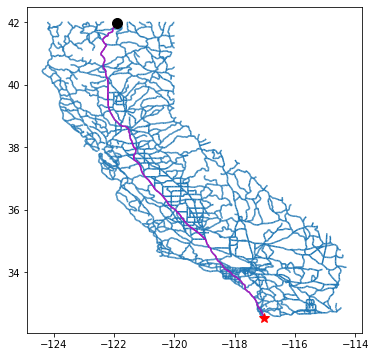

In [60]:
# This cell will plot a route. Feel free to edit the
# starting and finishing nodes to see other paths!

def plot_edgecoords(edgecoords, ax=None, color=None):
    from matplotlib.pyplot import gca
    from matplotlib.collections import LineCollection
    if ax is None: ax = gca()
    if color is None: color = ['m'] * len(edgecoords)
    ec = LineCollection(edgecoords, color=color)
    ax.add_collection(ec)
    
# Modify `start` and `finish`, if you want to see other paths!
# For example, uncomment the lines that pick random
# starting and ending nodes.
start = df_intersections["ID"].iloc[i_first]
finish = df_intersections["ID"].iloc[i_last]

#start = int(df_intersections["ID"].sample(1)) # Random start
#finish = int(df_intersections["ID"].sample(1)) # Random finish

print(f"Calculating a shortest path between nodes (intersections) {start} and {finish}...")
path = get_shortest_path(start, finish, G)
path_coords = path_to_coords(path, df_intersections)

plt.figure(figsize=(6, 6))
plot_roads(df_roads)
plot_point(*get_intersection_coords(start, df_intersections), 'ko')
plot_point(*get_intersection_coords(finish, df_intersections), 'r*')
plot_edgecoords(path_coords)

**Fin!** You’ve reached the end of this problem. Don’t forget to restart and run all cells again to make sure it’s all working when run in sequence; and make sure your work passes the submission process. Good luck!